<a href="https://colab.research.google.com/github/kato-taki/optimization-of-cultured-meat/blob/main/Sensitivity_analysis_(%CE%94t_%3D_48_h).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input

## Import library


In [ ]:
pip install SALib

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import math
import time
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import pandas as pd
import random
import statistics
import csv
from SALib.sample import saltelli
from SALib.analyze import sobol

## Parameter value and Constant value


In [ ]:
# モデルパラメータの初期値およびin vitro実験データから直接推定できるモデルパラメータの推定値
#動物細胞培養(C2C12マウス筋芽細胞)
#播種密度
X0_cell = 3.664e7     #cells/L, in vitro実験データを使用．
#最大比増殖速度
umax_cell   = 0.02650403895861364   #h-1, in vitro実験データから直接推定．
#培地成分（グルコース，乳酸，グルタミン，アンモニア）濃度
Cglc0_cell = 18.6505      #mmol/L, in vitro実験データを使用．
Clac0_cell = 8.5887       #mmol/L, in vitro実験データを使用．
Cgln0_cell = 1.4236       #mmol/L, in vitro実験データを使用．
Camm0_cell = 0.83965      #mmol/L, in vitro実験データを使用．
#増殖した細胞密度に対して代謝された培地成分（グルコース，乳酸，グルタミン，アンモニア）濃度の割合
qglc_cell = 2.69362e-7    #ΔCglc/ΔX (mmol/cells), in vitro実験データから直接推定．
qlac_cell = 3.88018e-7    #ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．
qgln_cell = 5.04417e-9    #ΔCgln/ΔX (mmol/cells), in vitro実験データから直接推定．
qamm_cell = 4.89619e-9   #ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．

#藻類培養 (synechococcus sp.)
#播種密度
X0_algae = 4.667e10   #cells/L, in vitro実験データを使用．
#最大比増殖速度
umax_algae   = 0.0036386896950844827  #h-1
#培地成分（グルコース，乳酸，グルタミン，アンモニア）濃度
Cglc0_algae = 18.6505      #mmol/L, in vitro実験データを使用．
Clac0_algae = 34.70       #mmol/L, in vitro実験データを使用．
Cgln0_algae = 1.4236       #mmol/L, in vitro実験データを使用．
Camm0_algae = 1.092      #mmol/L, in vitro実験データを使用．
#増殖した細胞密度に対して代謝された培地成分（グルコース，乳酸，グルタミン，アンモニア）濃度の割合
qglc_algae = 2.01938e-11  #ΔCglc/ΔX (mmol/cells), in vitro実験データから直接推定．
qlac_algae = 1.43009e-9   #ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．
qgln_algae = 1.35794e-11  #ΔCgln/ΔX (mmol/cells), in vitro実験データから直接推定．
qamm_algae = 1.0020686773617621e-10  #ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．

#藻類栄養素抽出
#酸加水分解によるグルコース抽出定数
kglc = 7.70751e-10  #mmol/cells

In [ ]:
# モデルパラメータの標準偏差 (SD) および変動係数 (CV)
#標準偏差 (SD)
#動物細胞培養
#初期細胞密度
SD_X0_cell =  X0_cell*8.648e-2
#最大比増殖速度
SD_umax_cell = umax_cell*8.104e-2
#主要成分のΔC/ΔX
SD_qglc_cell = qglc_cell*8.041e-2
SD_qgln_cell = qgln_cell*9.956e-2
SD_qlac_cell = qlac_cell*6.476e-2
SD_qamm_cell = qamm_cell*0.1323

#藻類培養
#播種密度
SD_X0_algae = X0_algae*1.293e-2
#最大比増殖速度
SD_umax_algae = umax_algae*0.1597
#主要成分のΔC/ΔX
SD_qglc_algae = qlac_algae*2.417
SD_qlac_algae = qlac_algae*0.2299
SD_qamm_algae = qamm_algae*0.1705
SD_qgln_algae = qgln_algae*1.201

#微細藻類酸加水分解
#酸加水分解によるグルコース抽出定数
SD_kglc = kglc*0.207


#変動係数 (CV)
#播種操作のばらつき
CV_X_cell_seed = 0.04
#培地濃度
#動物細胞培地
CV_Cglc0_cell = 1.701e-2
CV_Cgln0_cell = 6.962e-2
CV_Clac0_cell = 3.366e-2
CV_Camm0_cell = 0.1042

#藻類培地
CV_Cglc0_algae = 0.2072
CV_Clac0_algae = 4.389e-3
CV_Cgln0_algae = 0.1282
CV_Camm0_algae = 8.478e-2

In [ ]:
# in vitro実験データから直接推定できないモデルパラメータの初期推定値
#飽和定数KS
#動物細胞
Kglc = 0.582858586545957          #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
Kgln = 0.08698405384430127         #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
#藻類
Kamm_algae = 0.012646183541878239  #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．

#阻害定数KI
Klac_cell = 218.0659005245161      #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
Kamm_cell = 18.40334468820725     #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．

#グルタミン分解定数
kd_gln = 0.000096 #h-1, 文献データから引用し，推定値とする．

## Experimental condition

In [ ]:
# 実験条件
#1. CCC
#サイクル数
cycle_num = 2
#藻類から抽出したグルコースを添加した割合
k_hydrolysis = 5/100
#培地体積
V = 10 #L


#2. 感度解析
s = 32
## 感度解析パラメータの数
var = 21
## 試行回数
scale = s * (2 * var + 2) #scale = s * (2 * var + 2)

# Process

## Definition of culture process function

In [ ]:
# dtの定義
dt = 0.05  # タイムステップの値

#===============================================================================
#動物細胞培養プロセス
#===============================================================================
def cell_culture(t, y):
    X,Cglc,Clac,Cgln,Camm = y
    #1. 比増殖速度
    u = umax_cell *(Cglc/(Kglc+Cglc*(1+Clac/Klac_cell)))*(Cgln/(Kgln+Cgln*(1+Camm/Kamm_cell)))
    #2. 増殖速度式
    dXdt = u * X

    #3. 代謝速度式
    ##3.1 グルコース代謝
    dCglcdt = -qglc_cell * u * X
    ## Cglcが負の値をとらないようにする制約
    if Cglc + dCglcdt * dt < 0:
      dCglcdt = -Cglc / dt        # dt で割ることでタイムステップに基づいて調整
    ##3.2 乳酸代謝
    dClacdt = qlac_cell * u * X
    ##3.3 グルタミン代謝
    dCglndt = -qgln_cell * u * X - kd_gln * Cgln
    ## Cglnが負の値をとらないようにする制約
    if Cgln + dCglndt * dt < 0:
      dCglndt = -Cgln / dt
    ##3.4 アンモニア代謝
    dCammdt = qamm_cell * u * X + kd_gln * Cgln

    return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]

#動物細胞の比増殖速度
def u_cell(Cglc, Clac, Cgln, Camm):
  u = umax_cell *(Cglc/(Kglc+Cglc*(1+Clac/Klac_cell)))*(Cgln/(Kgln+Cgln*(1+Camm/Kamm_cell)))
  return u


#===============================================================================
#藻類培養プロセス
#===============================================================================
def algae_culture(t, y):
  X,Cglc,Clac,Cgln,Camm = y
  #1. 比増殖速度
  u = umax_algae *(Camm/(Kamm_algae+Camm))
  #2. 増殖速度式
  dXdt = u * X

  #3. 代謝速度式
  ##3.1 グルコース代謝
  dCglcdt = qglc_algae * u * X
  ##3.2 乳酸代謝
  dClacdt = -qlac_algae * u * X
  ## Clacが負の値をとらないようにする制約
  if Clac + dClacdt * dt < 0:
    dClacdt = -Clac / dt
  ##3.3 グルタミン代謝
  dCglndt = qgln_algae * u * X - kd_gln * Cgln
  ##3.4 アンモニア代謝
  dCammdt = -qamm_algae * u * X + kd_gln * Cgln
  ## Cammが負の値をとらないようにする制約
  if Camm + dCammdt * dt < 0:
    dCammdt = -Camm / dt

  return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]

#藻類の比増殖速度
def u_algae(Camm):
  u = umax_algae *(Camm/(Kamm_algae+Camm))
  return u

## Definition of CCC model

In [ ]:
# CCCモデルの定義
def CCC_model(umax_cell,umax_algae,qglc_cell,qlac_cell,qgln_cell,qamm_cell,qglc_algae,qlac_algae,qgln_algae,qamm_algae,kglc):

  #=============================================================================
  #CCCモデルの初期設定
  #=============================================================================
  #サンプルの生成
  problem = {
    'num_vars': var,
    'names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20','x21'],
    'bounds': [[X0_cell, 0.1*X0_cell],
      [X0_algae,    0.1*X0_algae],
      [umax_cell,   0.1*umax_cell],
      [umax_algae,  0.1*umax_algae],
      [qglc_cell,   0.1*qglc_cell],
      [qlac_cell,   0.1*qlac_cell],
      [qgln_cell,   0.1*qgln_cell],
      [qamm_cell,   0.1*qamm_cell],
      [qglc_algae,  0.1*qglc_algae],
      [qlac_algae,  0.1*qlac_algae],
      [qgln_algae,  0.1*qgln_algae],
      [qamm_algae,  0.1*qamm_algae],
      [Cglc0_cell,  Cglc0_cell  *0.1],
      [Clac0_cell,  Clac0_cell  *0.1],
      [Cgln0_cell,  Cgln0_cell  *0.1],
      [Camm0_cell,  Camm0_cell  *0.1],
      [Cglc0_algae, Cglc0_algae *0.1],
      [Clac0_algae, Clac0_algae *0.1],
      [Cgln0_algae, Cgln0_algae *0.1],
      [Camm0_algae, Camm0_algae *0.1],
      [kglc, 0.1*kglc]],
    'dists': ['norm'] * var
  }

  inputs = saltelli.sample(problem, scale)

  #モデルパラメータの経時変化を格納するリスト
  ##動物細胞
  list_X_cell     = [[]for i in range(scale)] #細胞密度
  list_u_cell     = [[]for i in range(scale)]  #比増殖速度
  list_Cglc_cell  = [[]for i in range(scale)] #グルコース濃度
  list_Clac_cell  = [[]for i in range(scale)] #乳酸濃度
  list_Cgln_cell  = [[]for i in range(scale)] #グルタミン濃度
  list_Camm_cell  = [[]for i in range(scale)] #アンモニア
  ##藻類
  list_X_algae    = [[]for i in range(scale)] #細胞密度
  list_u_algae    = [[]for i in range(scale)]  #比増殖速度
  list_Cglc_algae = [[]for i in range(scale)] #グルコース濃度
  list_Clac_algae = [[]for i in range(scale)] #乳酸濃度
  list_Cgln_algae = [[]for i in range(scale)] #グルタミン濃度
  list_Camm_algae = [[]for i in range(scale)] #アンモニア

  #培地交換後の濃度を格納するリスト
  ##動物細胞
  list_Cglc_cell_i  = [[]for i in range(scale)] #グルコース濃度
  list_Clac_cell_i  = [[]for i in range(scale)] #乳酸濃度
  list_Cgln_cell_i  = [[]for i in range(scale)] #グルタミン濃度
  list_Camm_cell_i  = [[]for i in range(scale)] #アンモニア濃度
  ##藻類
  list_Cglc_algae_i = [[]for i in range(scale)] #グルコース濃度
  list_Clac_algae_i = [[]for i in range(scale)] #乳酸濃度
  list_Cgln_algae_i = [[]for i in range(scale)] #グルタミン濃度
  list_Camm_algae_i = [[]for i in range(scale)] #アンモニア濃度


  #=============================================================================
  #CCCモデルの実行
  #=============================================================================
  for n in range(scale):
    #生成したサンプルから入力値を設定する
    umax_cell   = inputs[n][2]
    umax_algae  = inputs[n][3]
    qglc_cell   = inputs[n][4]
    qlac_cell   = inputs[n][5]
    qgln_cell   = inputs[n][6]
    qamm_cell   = inputs[n][7]
    qglc_algae  = inputs[n][8]
    qlac_algae  = inputs[n][9]
    qgln_algae  = inputs[n][10]
    qamm_algae  = inputs[n][11]
    kglc        = inputs[n][20]


    for i in range(cycle_num):
      #===========================================================================
      #1. 動物細胞培養プロセスの初期設定
      #===========================================================================
      # 1サイクル目の初期細胞密度と培地濃度の初期値の定義．
      if i == 0:
        #初期細胞密度
        X0 = inputs[n][0]
        #培地濃度
        Cglc0 = inputs[n][12]
        Clac0 = inputs[n][13]
        Cgln0 = inputs[n][14]
        Camm0 = inputs[n][15]
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]
      # 2サイクル目の初期細胞密度と培地濃度の初期値の定義．
      else:
        #初期細胞密度
        X0 = inputs[n][0]
        #培地濃度
        Cglc0 = list_Cglc_cell_i[n][-1]
        Clac0 = list_Clac_cell_i[n][-1]
        Cgln0 = list_Cgln_cell_i[n][-1]
        Camm0 = list_Camm_cell_i[n][-1]
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #===========================================================================
      #2. 動物細胞培養プロセスの実行
      #===========================================================================
      #培養期間の定義
      t_period = 48 #h
      t_span = (0, t_period)  # 時間範囲
      t_eval = np.linspace(*t_span, 960)  # 評価する時間点
      #動物細胞培養プロセスの計算
      sol = solve_ivp(cell_culture, t_span, y0, t_eval=t_eval)

      #リストに動物細胞培養の経時変化を格納する
      list_X_cell[n].extend(sol.y[0])
      list_Cglc_cell[n].extend(sol.y[1])
      list_Clac_cell[n].extend(sol.y[2])
      list_Cgln_cell[n].extend(sol.y[3])
      list_Camm_cell[n].extend(sol.y[4])

      #比増殖速度データの生成
      for x in range(len(sol.t)):
        list_u_cell[n].append(u_cell(sol.y[1][x],sol.y[2][x],sol.y[3][x],sol.y[4][x]))


      #===========================================================================
      #3. 藻類培養プロセスの初期設定
      #===========================================================================
      # 1サイクル目の初期細胞密度の定義．
      if i == 0:
        #初期細胞密度
        X0 = inputs[n][1]
        #培地濃度の初期値
        Cglc0 = inputs[n][16]
        Clac0 = inputs[n][17]
        Cgln0 = inputs[n][18]
        Camm0 = inputs[n][19]
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]
      # 2サイクル目の初期細胞密度と培地濃度の初期値の定義．
      else:
        #初期細胞密度
        X0 = inputs[n][1]
        #培地濃度
        Cglc0 = list_Cglc_algae_i[n][-1]
        Clac0 = list_Clac_algae_i[n][-1]
        Cgln0 = list_Cgln_algae_i[n][-1]
        Camm0 = list_Camm_algae_i[n][-1]
        y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #===========================================================================
      #4. 藻類培養プロセスの実行
      #===========================================================================
      #藻類培養プロセスの計算
      sol = solve_ivp(algae_culture, t_span, y0, t_eval=t_eval)

      #リストに藻類培養の経時変化を格納する
      list_X_algae[n].extend(sol.y[0])
      list_Cglc_algae[n].extend(sol.y[1])
      list_Clac_algae[n].extend(sol.y[2])
      list_Cgln_algae[n].extend(sol.y[3])
      list_Camm_algae[n].extend(sol.y[4])

      #比増殖速度データの生成
      for x in range(len(sol.t)):
        list_u_algae[n].append(u_algae(sol.y[4][x]))


      #===========================================================================
      #5. 藻類栄養素抽出プロセス
      #===========================================================================
      # 酸加水分解反応（藻類培地にグルコースを添加）
      list_Cglc_algae[n][-1]  = list_Cglc_algae[n][-1] + k_hydrolysis*kglc*list_X_algae[n][-1]


      #===========================================================================
      #6. 培地交換プロセス
      #===========================================================================
      #動物細胞培地
      list_Cglc_cell_i[n].append(list_Cglc_algae[n][-1])
      list_Clac_cell_i[n].append(list_Clac_algae[n][-1])
      list_Cgln_cell_i[n].append(list_Cgln_algae[n][-1])
      list_Camm_cell_i[n].append(list_Camm_algae[n][-1])

      #藻類培地
      list_Cglc_algae_i[n].append(list_Cglc_cell[n][-1])
      list_Clac_algae_i[n].append(list_Clac_cell[n][-1])
      list_Cgln_algae_i[n].append(list_Cgln_cell[n][-1])
      list_Camm_algae_i[n].append(list_Camm_cell[n][-1])


  #===========================================================================
  #CCCモデルの出力
  #===========================================================================
  #比増殖速度（感度解析したいモデルの出力）
  Y = []
  for i in range(scale):
    Y.append(list_u_cell[i][-1])

  #培地濃度(次の感度解析の入力)
  list_outputs = [list_Cglc_cell_i,list_Clac_cell_i,list_Cgln_cell_i,list_Camm_cell_i,list_Cglc_algae_i,list_Clac_algae_i,list_Cgln_algae_i,list_Camm_algae_i]
  next_inputs = np.zeros(len(list_outputs))
  for i in range(len(next_inputs)):
    next_inputs[i] = statistics.mean(list_outputs[i][j][-1]for j in range(scale))


  return problem,Y,next_inputs

# Output

## Sensitivity analysis

### *t* = 96 h

<ipython-input-34-9d8d140970f3>:35: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  inputs = saltelli.sample(problem, scale)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1408) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


           ST   ST_conf
x1   0.160504  0.436264
x2   0.002840  0.010713
x3   0.000000  0.000000
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
x16  0.000000  0.000000
x17  0.098416  0.328607
x18  0.004185  0.013198
x19  0.001185  0.003991
x20  0.000471  0.001615
x21  0.005140  0.022959
           S1   S1_conf
x1   0.475173  0.289953
x2   0.016872  0.029371
x3   0.000000  0.000000
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
x16  0.000000  0.000000
x17  0.340237  0.273617
x18  0.033288  0.056741
x19 -0.005262  0

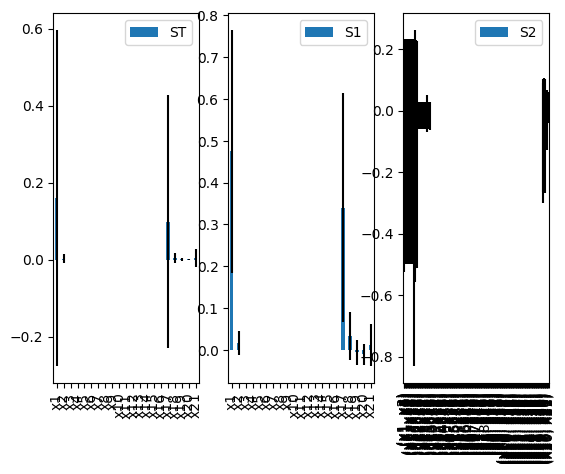

In [ ]:
# Model outputs
problem,Y,next_inputs = CCC_model(umax_cell,umax_algae,qglc_cell,qlac_cell,qgln_cell,qamm_cell,qglc_algae,qlac_algae,qgln_algae,qamm_algae,kglc)

# Perform analysis
Y = np.array(Y)
Si = sobol.analyze(problem, Y, print_to_console=True)

Si.plot()
plot.show()

### *t* = 192 h

<ipython-input-34-9d8d140970f3>:35: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  inputs = saltelli.sample(problem, scale)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1408) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


           ST   ST_conf
x1   1.000275  0.255349
x2   0.099447  0.089528
x3   0.000000  0.000000
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
x16  0.000000  0.000000
x17  1.453726  1.415753
x18  1.225768  1.230394
x19  0.008229  0.035594
x20  0.000503  0.000492
x21  0.499154  0.470390
           S1   S1_conf
x1   0.381304  1.382342
x2  -0.021772  0.193113
x3   0.000000  0.000000
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
x16  0.000000  0.000000
x17 -0.088849  1.042980
x18 -0.078905  0.267478
x19 -0.006061  0

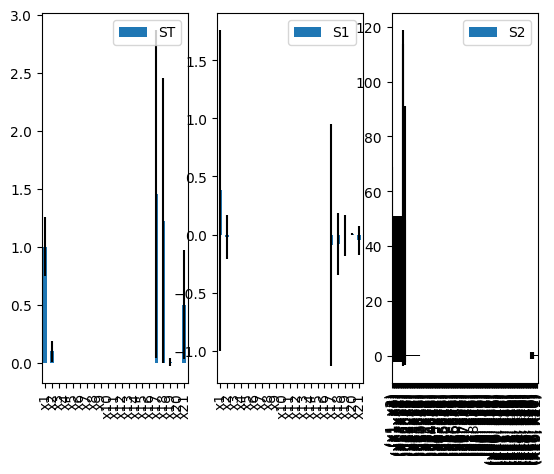

In [ ]:
# Model inputs
Cglc0_cell = next_inputs[0]
Clac0_cell = next_inputs[1]
Cgln0_cell = next_inputs[2]
Camm0_cell = next_inputs[3]
Cglc0_algae = next_inputs[4]
Clac0_algae = next_inputs[5]
Cgln0_algae = next_inputs[6]
Camm0_algae = next_inputs[7]

# Model outputs
problem,Y,next_inputs = CCC_model(umax_cell,umax_algae,qglc_cell,qlac_cell,qgln_cell,qamm_cell,qglc_algae,qlac_algae,qgln_algae,qamm_algae,kglc)

# Perform analysis (auto display)
Y = np.array(Y)
Si = sobol.analyze(problem, Y, print_to_console=True)

Si.plot()
plot.show()

### *t* = 288 h

<ipython-input-34-9d8d140970f3>:35: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  inputs = saltelli.sample(problem, scale)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1408) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


           ST   ST_conf
x1   1.621157  2.909732
x2   1.247868  4.272934
x3   0.000000  0.000000
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
x16  0.000000  0.000000
x17  0.000334  0.001111
x18  0.493266  1.157511
x19  1.100633  3.560078
x20  0.237788  0.412157
x21  0.690006  1.749729
           S1   S1_conf
x1   0.260343  0.616618
x2  -0.221749  0.534966
x3   0.000000  0.000000
x4   0.000000  0.000000
x5   0.000000  0.000000
x6   0.000000  0.000000
x7   0.000000  0.000000
x8   0.000000  0.000000
x9   0.000000  0.000000
x10  0.000000  0.000000
x11  0.000000  0.000000
x12  0.000000  0.000000
x13  0.000000  0.000000
x14  0.000000  0.000000
x15  0.000000  0.000000
x16  0.000000  0.000000
x17  0.002148  0.007119
x18 -0.143036  0.269646
x19 -0.143180  0

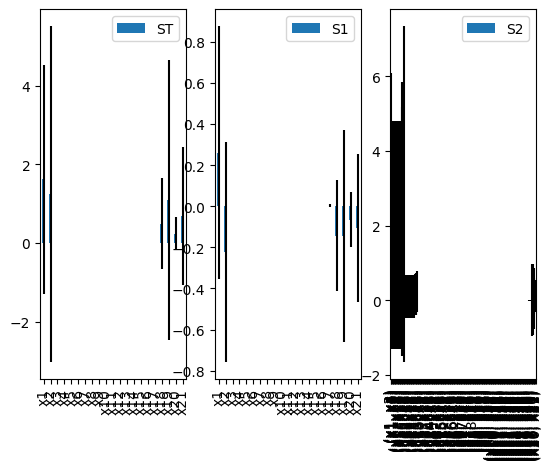

In [ ]:
# Model inputs
Cglc0_cell = next_inputs[0]
Clac0_cell = next_inputs[1]
Cgln0_cell = next_inputs[2]
Camm0_cell = next_inputs[3]
Cglc0_algae = next_inputs[4]
Clac0_algae = next_inputs[5]
Cgln0_algae = next_inputs[6]
Camm0_algae = next_inputs[7]

# Model outputs
problem,Y,next_inputs = CCC_model(umax_cell,umax_algae,qglc_cell,qlac_cell,qgln_cell,qamm_cell,qglc_algae,qlac_algae,qgln_algae,qamm_algae,kglc)

# Perform analysis (auto display)
Y = np.array(Y)
Si = sobol.analyze(problem, Y, print_to_console=True)

Si.plot()
plot.show()

### *t* = 384 h

<ipython-input-34-9d8d140970f3>:35: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  inputs = saltelli.sample(problem, scale)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1408) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


               ST       ST_conf
x1   1.177568e+00  1.054023e+00
x2   7.180038e-01  5.135052e-01
x3   0.000000e+00  0.000000e+00
x4   0.000000e+00  0.000000e+00
x5   0.000000e+00  0.000000e+00
x6   0.000000e+00  0.000000e+00
x7   0.000000e+00  0.000000e+00
x8   0.000000e+00  0.000000e+00
x9   0.000000e+00  0.000000e+00
x10  0.000000e+00  0.000000e+00
x11  0.000000e+00  0.000000e+00
x12  0.000000e+00  0.000000e+00
x13  0.000000e+00  0.000000e+00
x14  0.000000e+00  0.000000e+00
x15  0.000000e+00  0.000000e+00
x16  0.000000e+00  0.000000e+00
x17  1.738189e-12  1.794883e-12
x18  6.865210e-01  4.718219e-01
x19  8.173665e-01  6.169126e-01
x20  8.209283e-01  1.310486e+00
x21  1.042292e+00  1.005641e+00
               S1       S1_conf
x1   1.652586e-01  2.725251e-01
x2   3.382294e-02  1.916295e-01
x3   0.000000e+00  0.000000e+00
x4   0.000000e+00  0.000000e+00
x5   0.000000e+00  0.000000e+00
x6   0.000000e+00  0.000000e+00
x7   0.000000e+00  0.000000e+00
x8   0.000000e+00  0.000000e+00
x9   0.0

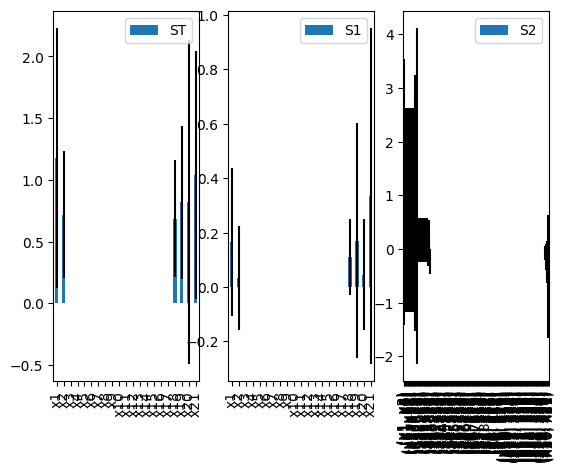

In [ ]:
# Model inputs
Cglc0_cell = next_inputs[0]
Clac0_cell = next_inputs[1]
Cgln0_cell = next_inputs[2]
Camm0_cell = next_inputs[3]
Cglc0_algae = next_inputs[4]
Clac0_algae = next_inputs[5]
Cgln0_algae = next_inputs[6]
Camm0_algae = next_inputs[7]

# Model outputs
problem,Y,next_inputs = CCC_model(umax_cell,umax_algae,qglc_cell,qlac_cell,qgln_cell,qamm_cell,qglc_algae,qlac_algae,qgln_algae,qamm_algae,kglc)

# Perform analysis (auto display)
Y = np.array(Y)
Si = sobol.analyze(problem, Y, print_to_console=True)

Si.plot()
plot.show()

### *t* = 480 h

<ipython-input-34-9d8d140970f3>:35: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  inputs = saltelli.sample(problem, scale)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1408) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/usr/local/lib/python3.10/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


               ST       ST_conf
x1   1.713395e+00  2.393593e+00
x2   2.354970e-01  3.709189e-01
x3   0.000000e+00  0.000000e+00
x4   0.000000e+00  0.000000e+00
x5   0.000000e+00  0.000000e+00
x6   0.000000e+00  0.000000e+00
x7   0.000000e+00  0.000000e+00
x8   0.000000e+00  0.000000e+00
x9   0.000000e+00  0.000000e+00
x10  0.000000e+00  0.000000e+00
x11  0.000000e+00  0.000000e+00
x12  0.000000e+00  0.000000e+00
x13  0.000000e+00  0.000000e+00
x14  0.000000e+00  0.000000e+00
x15  0.000000e+00  0.000000e+00
x16  0.000000e+00  0.000000e+00
x17  7.344331e-12  1.821488e-11
x18  2.182589e-01  3.679760e-01
x19  3.110080e-01  5.952445e-01
x20  4.449332e-01  1.477728e+00
x21  1.607559e+00  3.045145e+00
               S1   S1_conf
x1   4.428130e-01  0.867951
x2  -2.355910e-01  0.383699
x3   0.000000e+00  0.000000
x4   0.000000e+00  0.000000
x5   0.000000e+00  0.000000
x6   0.000000e+00  0.000000
x7   0.000000e+00  0.000000
x8   0.000000e+00  0.000000
x9   0.000000e+00  0.000000
x10  0.000000e+0

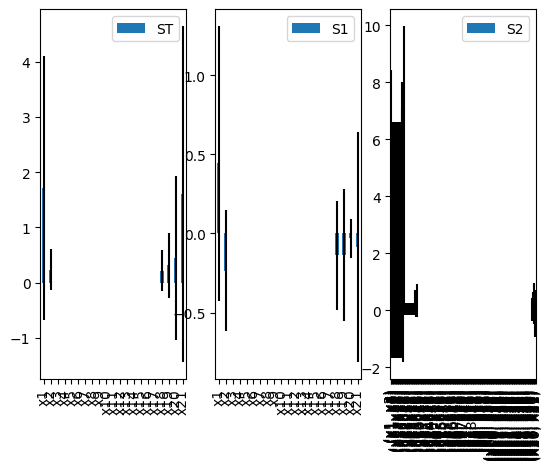

In [ ]:
# Model inputs
Cglc0_cell = next_inputs[0]
Clac0_cell = next_inputs[1]
Cgln0_cell = next_inputs[2]
Camm0_cell = next_inputs[3]
Cglc0_algae = next_inputs[4]
Clac0_algae = next_inputs[5]
Cgln0_algae = next_inputs[6]
Camm0_algae = next_inputs[7]

# Model outputs
problem,Y,next_inputs = CCC_model(umax_cell,umax_algae,qglc_cell,qlac_cell,qgln_cell,qamm_cell,qglc_algae,qlac_algae,qgln_algae,qamm_algae,kglc)

# Perform analysis (auto display)
Y = np.array(Y)
Si = sobol.analyze(problem, Y, print_to_console=True)

Si.plot()
plot.show()